In [7]:
from pathlib import Path
from warnings import filterwarnings

# Silence some expected warnings
filterwarnings("ignore")

import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import MACCSkeys, Draw, AllChem, DataStructs, PandasTools
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns

# Neural network specific libraries
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import ModelCheckpoint

%matplotlib inline

In [2]:
df = pd.read_csv('data_all.csv', index_col= 0)
df

,canonical_smiles,pchembl_value
molecule_chembl_id,,
CHEMBL1795572,CO/N=C(/C(=O)NCP(=O)(O)Oc1ccc(C#N)c(F)c1)c1ccc...,4.51
CHEMBL3112752,N[C@@H](Cc1ccc(NC(=O)[C@@H]2CC[C@@H]3CN2C(=O)N...,4.55
CHEMBL3112746,O=C(Nc1ccncc1)[C@@H]1CC[C@@H]2CN1C(=O)N2OS(=O)...,4.70
CHEMBL1173339,CCC(S)P(=O)(OC(C)C)OC(C)C,5.70
CHEMBL1172388,CCC(S)P(=O)(O)O,4.82
...,...,...
CHEMBL4088285,CC(=O)SCC(CCCc1ccccc1)c1nnn[nH]1,4.38
CHEMBL4064978,CC(=O)SCC(Cc1ccccc1)c1nnn[nH]1,4.17
CHEMBL4075406,O=P(O)(O)C(CO)CCCCc1ccccc1,5.35


In [3]:
print( f'number of missing values are : {df.isnull().sum().sum()}')
print (f'The shape of the dataset is : {df.shape}')

number of missing values are : 16
The shape of the dataset is : (62242, 2)


In [4]:
df = df.dropna(how='any')

In [5]:
print( f'number of missing values are : {df.isnull().sum().sum()}')
print (f'The shape of the dataset is : {df.shape}')

number of missing values are : 0
The shape of the dataset is : (62226, 2)


In [11]:
PandasTools.AddMoleculeColumnToFrame(df, smilesCol='canonical_smiles')

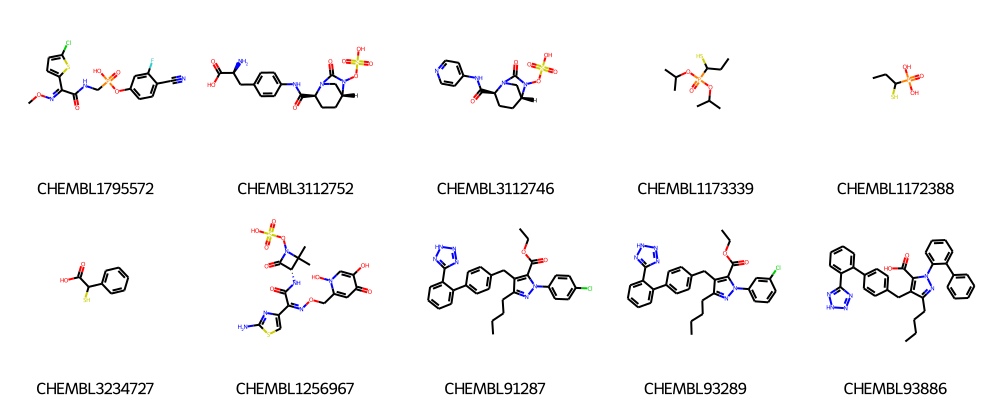

In [21]:
Draw.MolsToGridImage(list(df.ROMol[0:10]), legends = list(df.index[0:10]), molsPerRow=5)

In [6]:
#mols = [Chem.MolFromSmiles(smi) for smi in df.canonical_smiles ]

In [8]:
mols = [Chem.MolFromSmiles(smi) for smi in df.canonical_smiles ]
fp = [AllChem.GetMorganFingerprintAsBitVect(m, 2) for m in mols]

In [15]:
def smiles_to_fp(smiles, method="maccs", n_bits=2048):
    """
    Encode a molecule from a SMILES string into a fingerprint.

    Parameters
    ----------
    smiles : str
        The SMILES string defining the molecule.

    method : str
        The type of fingerprint to use. Default is MACCS keys.

    n_bits : int
        The length of the fingerprint.

    Returns
    -------
    array
        The fingerprint array.

    """

    # convert smiles to RDKit mol object
    mol = Chem.MolFromSmiles(smiles)

    if method == "maccs":
        return np.array(MACCSkeys.GenMACCSKeys(mol))
    if method == "morgan2":
        return np.array(GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits))
    if method == "morgan3":
        return np.array(GetMorganFingerprintAsBitVect(mol, 3, nBits=n_bits))
    else:
        # NBVAL_CHECK_OUTPUT
        print(f"Warning: Wrong method specified: {method}. Default will be used instead.")
        return np.array(MACCSkeys.GenMACCSKeys(mol))



,canonical_smiles,pchembl_value,ROMol,fp
molecule_chembl_id,,,,
CHEMBL1795572,CO/N=C(/C(=O)NCP(=O)(O)Oc1ccc(C#N)c(F)c1)c1ccc...,4.51,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
CHEMBL3112752,N[C@@H](Cc1ccc(NC(=O)[C@@H]2CC[C@@H]3CN2C(=O)N...,4.55,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
CHEMBL3112746,O=C(Nc1ccncc1)[C@@H]1CC[C@@H]2CN1C(=O)N2OS(=O)...,4.70,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."

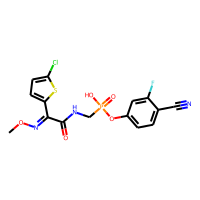
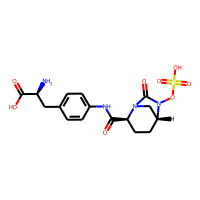
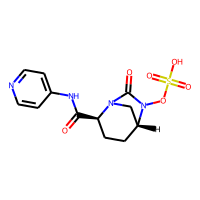

In [16]:
# Add column for fingerprint
df["fp"] = df["canonical_smiles"].apply(smiles_to_fp)
df.head(3)
# NBVAL_CHECK_OUTPUT

### The fp_from_smiles function is very slow and running it kill the kernel of the jupyter 

In [9]:
# def fp_from_smiles(smiles):
#     output = []
#     for f in fp :
#         arr = np.zeros((1,))
#         DataStructs.ConvertToNumpyArray(f, arr)
#         output.append(arr)
#     return np.asarray(output)
#     #return pd.DataFrame(data = output, index= df.index)

In [10]:
# df["canonical_smiles"]

molecule_chembl_id
CHEMBL1795572    CO/N=C(/C(=O)NCP(=O)(O)Oc1ccc(C#N)c(F)c1)c1ccc...
CHEMBL3112752    N[C@@H](Cc1ccc(NC(=O)[C@@H]2CC[C@@H]3CN2C(=O)N...
CHEMBL3112746    O=C(Nc1ccncc1)[C@@H]1CC[C@@H]2CN1C(=O)N2OS(=O)...
CHEMBL1173339                            CCC(S)P(=O)(OC(C)C)OC(C)C
CHEMBL1172388                                      CCC(S)P(=O)(O)O
                                       ...                        
CHEMBL4088285                     CC(=O)SCC(CCCc1ccccc1)c1nnn[nH]1
CHEMBL4064978                       CC(=O)SCC(Cc1ccccc1)c1nnn[nH]1
CHEMBL4075406                           O=P(O)(O)C(CO)CCCCc1ccccc1
CHEMBL4069211                            O=P(O)(O)C(CO)CCCc1ccccc1
CHEMBL4087458                       CCOP(=O)(OCC)C(CS)CCCCc1ccccc1
Name: canonical_smiles, Length: 62226, dtype: object

In [ ]:
# df["fingerprints_df"] = df["canonical_smiles"].apply(fp_from_smiles)

# # Look at head
# print("Shape of dataframe:", df.shape)
# df.head(3)
# # NBVAL_CHECK_OUTPUT

In [61]:
df.to_csv('data_fp.csv', index=True)

In [62]:
df = pd.read_csv('../beta-lactamase/data_fp.csv', index_col=0)
df.head()

,canonical_smiles,pchembl_value,ROMol,fp
molecule_chembl_id,,,,
CHEMBL1795572,CO/N=C(/C(=O)NCP(=O)(O)Oc1ccc(C#N)c(F)c1)c1ccc...,4.51,"<img data-content=""rdkit/molecule"" src=""data:i...",[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...
CHEMBL3112752,N[C@@H](Cc1ccc(NC(=O)[C@@H]2CC[C@@H]3CN2C(=O)N...,4.55,"<img data-content=""rdkit/molecule"" src=""data:i...",[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0...
CHEMBL3112746,O=C(Nc1ccncc1)[C@@H]1CC[C@@H]2CN1C(=O)N2OS(=O)...,4.70,"<img data-content=""rdkit/molecule"" src=""data:i...",[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0...
CHEMBL1173339,CCC(S)P(=O)(OC(C)C)OC(C)C,5.70,"<img data-content=""rdkit/molecule"" src=""data:i...",[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...
CHEMBL1172388,CCC(S)P(=O)(O)O,4.82,"<img data-content=""rdkit/molecule"" src=""data:i...",[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...


In [63]:
df['fp'][0].

'[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 1\n 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0\n 0 0 0 0 1 1 0 1 1 1 0 0 0 1 1 1 0 0 1 1 1 1 1 1 0 0 1 0 1 1 1 0 1 1 0 0 1\n 0 1 1 0 0 0 1 0 1 0 0 0 0 1 1 1 1 0 0 1 1 1 0 1 0 1 1 0 1 1 0 1 1 1 0 1 0\n 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]'

In [70]:
ls

01_Acetylcholinesterase_dataset_from_chembl.ipynb
02_telomerase_dataset_from_chembl.ipynb
beta_lactamase_QSAR.ipynb
beta_lactame_deep_learning.ipynb
_config.yml
databases/
data_fp.csv
data-test
data-test.sdf
Deep_leanring.ipynb
Firstmodel.pickle
README.md
SecondModel.h5
StatefulModel.h5
TasteDB.smi
telomerase_database_with_descriptors.csv
telomerase_IC50_pIC50_bioactivity_data_curated.csv
telomerase_IC50_pIC50_bioactivity_data_curated_without_abberant_values.csv
ThirdModel.h5
Tuto1_Read_and_reading__molecules.ipynb
Tuto2_Moleuclar_properties.ipynb
Untitled1-Copy1.ipynb
Untitled1.ipynb
Untitled.ipynb


In [69]:
df['fp'].apply(pd.to_numeric, downcast='float')

ValueError: Unable to parse string "[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 1
 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0
 0 0 0 0 1 1 0 1 1 1 0 0 0 1 1 1 0 0 1 1 1 1 1 1 0 0 1 0 1 1 1 0 1 1 0 0 1
 0 1 1 0 0 0 1 0 1 0 0 0 0 1 1 1 1 0 0 1 1 1 0 1 0 1 1 0 1 1 0 1 1 1 0 1 0
 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]" at position 0

In [64]:
df['fp'].isna()

molecule_chembl_id
CHEMBL1795572    False
CHEMBL3112752    False
CHEMBL3112746    False
CHEMBL1173339    False
CHEMBL1172388    False
                 ...  
CHEMBL4088285    False
CHEMBL4064978    False
CHEMBL4075406    False
CHEMBL4069211    False
CHEMBL4087458    False
Name: fp, Length: 62226, dtype: bool

In [45]:
data_columns = df.columns 
data_indices = df.index

In [47]:
df = (df.drop(columns= data_columns, axis=1).join(df[data_columns]).apply(pd.to_numeric, errors='coerce'))

In [55]:
df.head()

,canonical_smiles,pchembl_value,ROMol,fp
molecule_chembl_id,,,,
CHEMBL1795572,NaN,4.51,NaN,NaN
CHEMBL3112752,NaN,4.55,NaN,NaN
CHEMBL3112746,NaN,4.70,NaN,NaN
CHEMBL1173339,NaN,5.70,NaN,NaN
CHEMBL1172388,NaN,4.82,NaN,NaN


In [48]:
# Split the data into training and test set
x_train, x_test, y_train, y_test = train_test_split(
    df["fp"], df[["pchembl_value"]], test_size=0.3, random_state=42
)

# Print the shape of training and testing data
print("Shape of training data:", x_train.shape)
print("Shape of test data:", x_test.shape)
# NBVAL_CHECK_OUTPUT

Shape of training data: (43558,)
Shape of test data: (18668,)


In [49]:
def NN_model(shape):
    model = Sequential()
    model.add(Input(shape, name= 'InputLayer'))
    model.add(Dense(32, activation= 'relu', name = 'hiden1'))
    model.add(Dense(64, activation= 'relu', name = 'hiden2'))
    model.add(Dense(32, activation= 'relu', name = 'hiden3'))
    model.add(Dense(1, activation= 'linear', name= 'Output'))
    model.compile(optimizer = 'adam',
                 loss = 'mse',
                 metrics = ['mae', 'mse'])
    return model

In [50]:
df.shape[0]

62226

In [51]:
model = NN_model((1,))
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hiden1 (Dense)               (None, 32)                64        
_________________________________________________________________
hiden2 (Dense)               (None, 64)                2112      
_________________________________________________________________
hiden3 (Dense)               (None, 32)                2080      
_________________________________________________________________
Output (Dense)               (None, 1)                 33        
Total params: 4,289
Trainable params: 4,289
Non-trainable params: 0
_________________________________________________________________


In [52]:
history = model.fit(x_train,
                   y_train,
                batch_size=60,
                epochs=10,
                verbose=1, 
                validation_data=(x_test.astype(float), y_test))

Epoch 1/10
726/726 [==============================] - 6s 8ms/step - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 2/10
726/726 [==============================] - 5s 7ms/step - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 3/10
726/726 [==============================] - 5s 7ms/step - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 4/10
726/726 [==============================] - 6s 8ms/step - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 5/10
726/726 [==============================] - 5s 7ms/step - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 6/10
726/726 [==============================] - 5s 7ms/step - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 7/10
726/726 [==============================] - 5s 7ms/step - loss: nan - mae: nan - mse: nan - val_loss: nan - val_ma

In [53]:
# Neural network parameters
shape = (1,)
batch_sizes = [16, 32, 64]
nb_epoch = 5

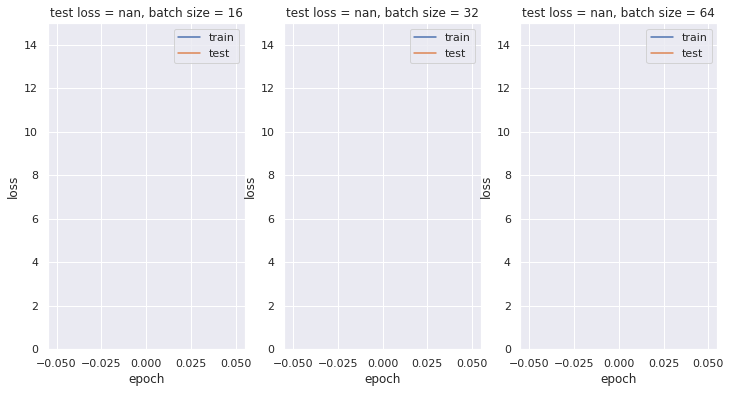

In [54]:
# Plot
fig = plt.figure(figsize=(12, 6))
sns.set(color_codes=True)
for index, batch in enumerate(batch_sizes):
    fig.add_subplot(1, len(batch_sizes), index + 1)
    model = NN_model(shape=shape)

    # Fit model on x_train, y_train data
    history = model.fit(
        np.array(list((x_train))),
        y_train.values,
        batch_size=batch,
        validation_data=(np.array(list((x_test))), y_test.values),
        verbose=0,
        epochs=nb_epoch,
    )
    plt.plot(history.history["loss"], label="train")
    plt.plot(history.history["val_loss"], label="test")
    plt.legend(["train", "test"], loc="upper right")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.ylim((0, 15))
    plt.title(
        f"test loss = {history.history['val_loss'][nb_epoch-1]:.2f}, " f"batch size = {batch}"
    )
plt.show()